# Spaceship Titanic

Project Summary: The Spaceship Titanic was an interstellar passenger liner carrying nearly 13 000 people to newly discovered exoplanets. During its maiden voyage in 2912, it collided with a spacetime anomaly near Alpha Centauri. While the ship remained intact, nearly half of the passengers mysteriously vanished into another dimension.

Goal: Analyze the passenger data and apply machine learning techniques to predict which individuals were transported by the anomaly. Help uncover the mystery and assist in the rescue mission.

Source of Data: [Spaceship Titanic Data](https://www.kaggle.com/competitions/spaceship-titanic/data)

Project Objectives:
* Perform Exploratory Data Analysis (EDA),
* Conduct Statistical Inference,
* Develop Predictive Models,
* Optimize Model Performance,
* Communicate Findings Clearly,
* Propose Improvements.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import math
from statsmodels.stats.proportion import proportion_confint
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from pandas.api.types import CategoricalDtype
from scipy.stats import pearsonr, chi2_contingency
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    f1_score,
    roc_auc_score,
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import optuna
from optuna import create_study
from sklearn.ensemble import VotingClassifier
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
train_df = pd.read_csv("train.csv")
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
print("Train Data:", train_df.shape)

Train Data: (8693, 14)


About Variables:
* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

## Data Cleaning

### Data Type

In [4]:
train_df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

* Categorical variables: PassengerId, HomePlanet, CryoSleep, Cabin, Destination, VIP, Name and Transported.
* Numeric variables: Age, RoomService, FoodCourt, ShoppingMall, Spa abd VRDeck.

### Missing Values

In [5]:
missing_info = pd.DataFrame(
    {
        "Missing Count": train_df.isnull().sum(),
        "Missing %": (train_df.isnull().sum() / len(train_df) * 100).round(2),
    }
)

missing_info

,Missing Count,Missing %
PassengerId,0,0.00
HomePlanet,201,2.31
CryoSleep,217,2.50
Cabin,199,2.29
Destination,182,2.09
Age,179,2.06
VIP,203,2.34
RoomService,181,2.08
FoodCourt,183,2.11
ShoppingMall,208,2.39


We seem to have a missing values in all columns except passengerid and transported, but missing values about 2 % which is not a lot.

Filling missing values:
* For numeric variable we going to fill them with median,
* For categorical we going to fill them with mode,
* For name and cabin we going to fill them with "Uknown".

In [6]:
for col in ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]:
    train_df[col].fillna(train_df[col].median(), inplace=True)

for col in ["HomePlanet", "CryoSleep", "Destination", "VIP"]:
    train_df[col].fillna(train_df[col].mode()[0], inplace=True)

for col in ["Cabin", "Name"]:
    train_df[col].fillna("Unknown", inplace=True)

missing_info = pd.DataFrame(
    {
        "Missing Count": train_df.isnull().sum(),
        "Missing %": (train_df.isnull().sum() / len(train_df) * 100).round(2),
    }
)

missing_info

,Missing Count,Missing %
PassengerId,0,0.0
HomePlanet,0,0.0
CryoSleep,0,0.0
Cabin,0,0.0
Destination,0,0.0
Age,0,0.0
VIP,0,0.0
RoomService,0,0.0
FoodCourt,0,0.0
ShoppingMall,0,0.0


There is no more missing values.

### Duplicated Rows

In [7]:
print(train_df.duplicated().sum())

0


There is no duplicated rows.

### Creating Features

#### Group size and travels alone

In [8]:
group_id = train_df["PassengerId"].apply(lambda x: x.split("_")[0])
train_df["group_size"] = group_id.map(group_id.value_counts())
train_df["travels_alone"] = train_df["group_size"] == 1

#### Deck, number and side.

In [9]:
train_df[["Deck", "Number", "Side"]] = train_df["Cabin"].str.split("/", expand=True)
train_df["Number"] = pd.to_numeric(train_df["Number"], errors="coerce").astype("Int64")

Dropping columns

In [10]:
train_df.drop(columns=["PassengerId", "Name", "Cabin"], inplace=True)

## Exploratory Data Analysis

### Distribution of Transported (target variable)

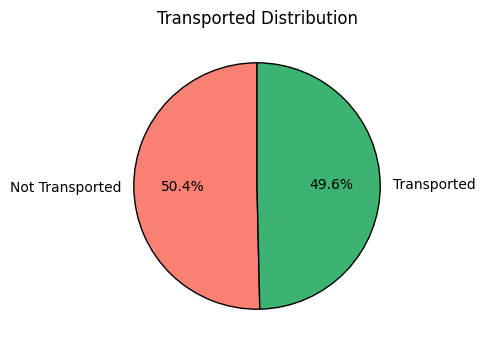

In [11]:
plt.figure(figsize=(5, 4))

stroke_counts = train_df["Transported"].value_counts()
labels = ["Not Transported", "Transported"]

colors = ["salmon", "mediumseagreen"]

plt.pie(
    stroke_counts,
    labels=labels,
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
    wedgeprops={"edgecolor": "black"},
)
plt.title("Transported Distribution")
plt.show()

We see that transported is equaly distributed with almost 50 and 50.

### Numeric Variable

In [12]:
train_df.describe().round(2)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,group_size,Number
count,8693.00,8693.00,8693.00,8693.00,8693.00,8693.00,8693.00,8494.0
mean,28.79,220.01,448.43,169.57,304.59,298.26,2.04,600.37
std,14.34,660.52,1595.79,598.01,1125.56,1134.13,1.60,511.87
min,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.0
25%,20.00,0.00,0.00,0.00,0.00,0.00,1.00,167.25
50%,27.00,0.00,0.00,0.00,0.00,0.00,1.00,427.0
75%,37.00,41.00,61.00,22.00,53.00,40.00,3.00,999.0
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00,8.00,1894.0


* Age varies from 0 to 79 with mean being 28.79,
* RoomService varies from 0 to 14 327, with mean being 220.01,
* FoodCourt varies from 0 to 29 813, with mean being 448.43,
* ShoppingMall varies from 0 to 23 492, with mean being 169.57,
* Spa varies from 0 to 22 408, with mean being 304.59,
* VRDeck varies from 0 to 24 133, with mean being 298.26,
* group_size varies from 1 to 8, with mean being 2.04,
* Number varies from 0 to 1 894.

Outliers detected in Age: 162
Outliers detected in RoomService: 1906
Outliers detected in FoodCourt: 1916
Outliers detected in ShoppingMall: 1879
Outliers detected in Spa: 1833
Outliers detected in VRDeck: 1849
Outliers detected in group_size: 335
Outliers detected in Number: 0


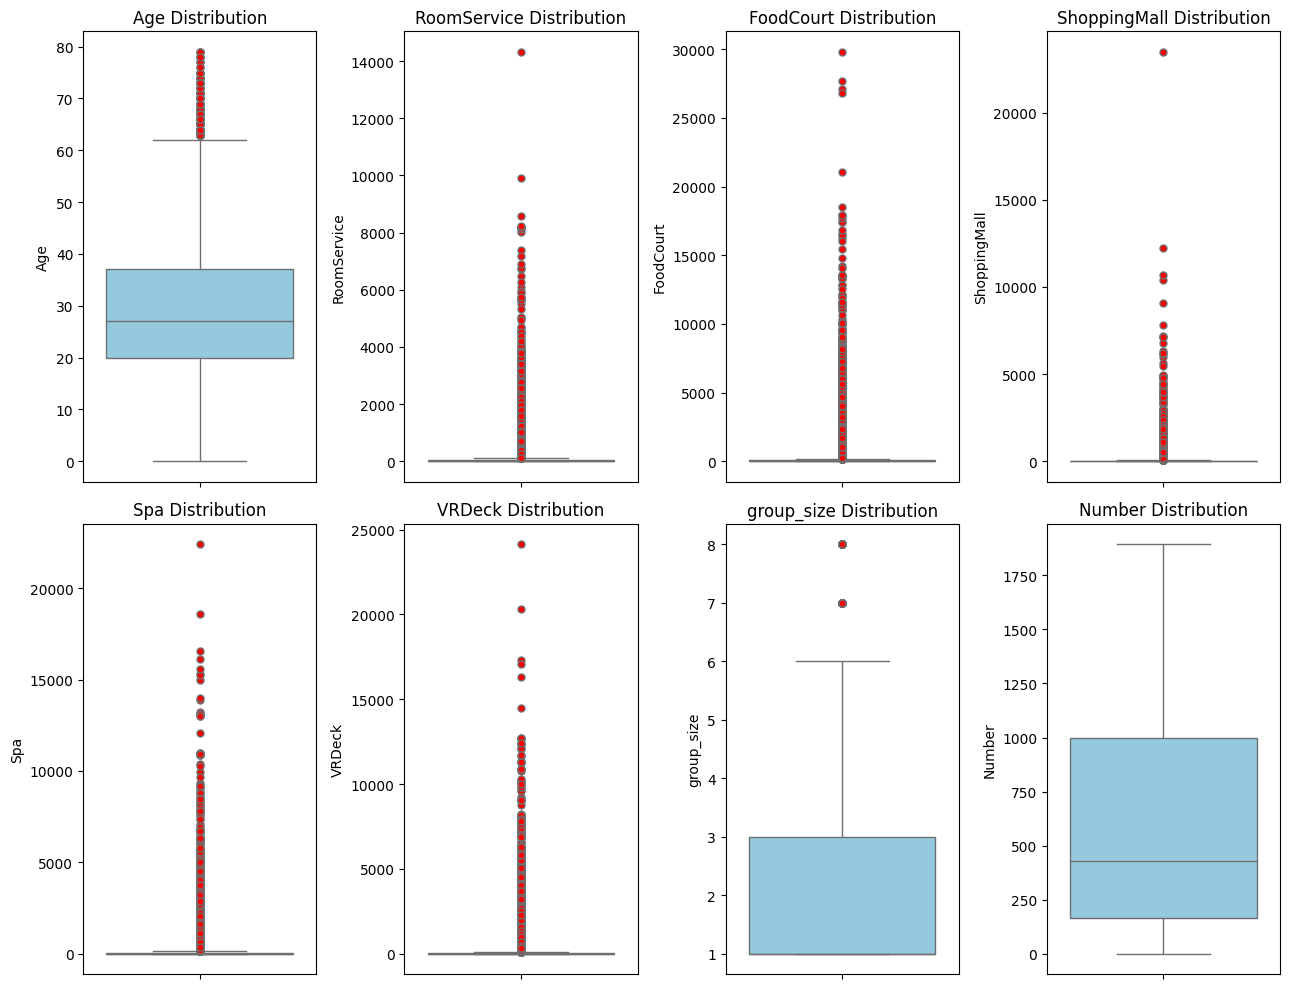

In [13]:
numeric = [
    "Age",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "group_size",
    "Number",
]

for col in numeric:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = train_df[(train_df[col] < lower_bound) | (train_df[col] > upper_bound)]
    print(f"Outliers detected in {col}: {outliers.shape[0]}")


fig, axes = plt.subplots(
    int(np.ceil(len(numeric) / 4)), 4, figsize=(13, 5 * np.ceil(len(numeric) / 4))
)
axes = axes.flatten()

for i, col in enumerate(numeric):
    sns.boxplot(
        y=train_df[col],
        color="skyblue",
        ax=axes[i],
        flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 5},
    )
    axes[i].set_title(f"{col} Distribution")
    axes[i].set_ylabel(col)

for i in range(len(numeric), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()

The outliers identified are mainly from high spenders and large group sizes, which reflect valid but rare passenger behaviors. We going to keep them in the dataset to preserve the full range of passenger activity for a more accurate analysis.

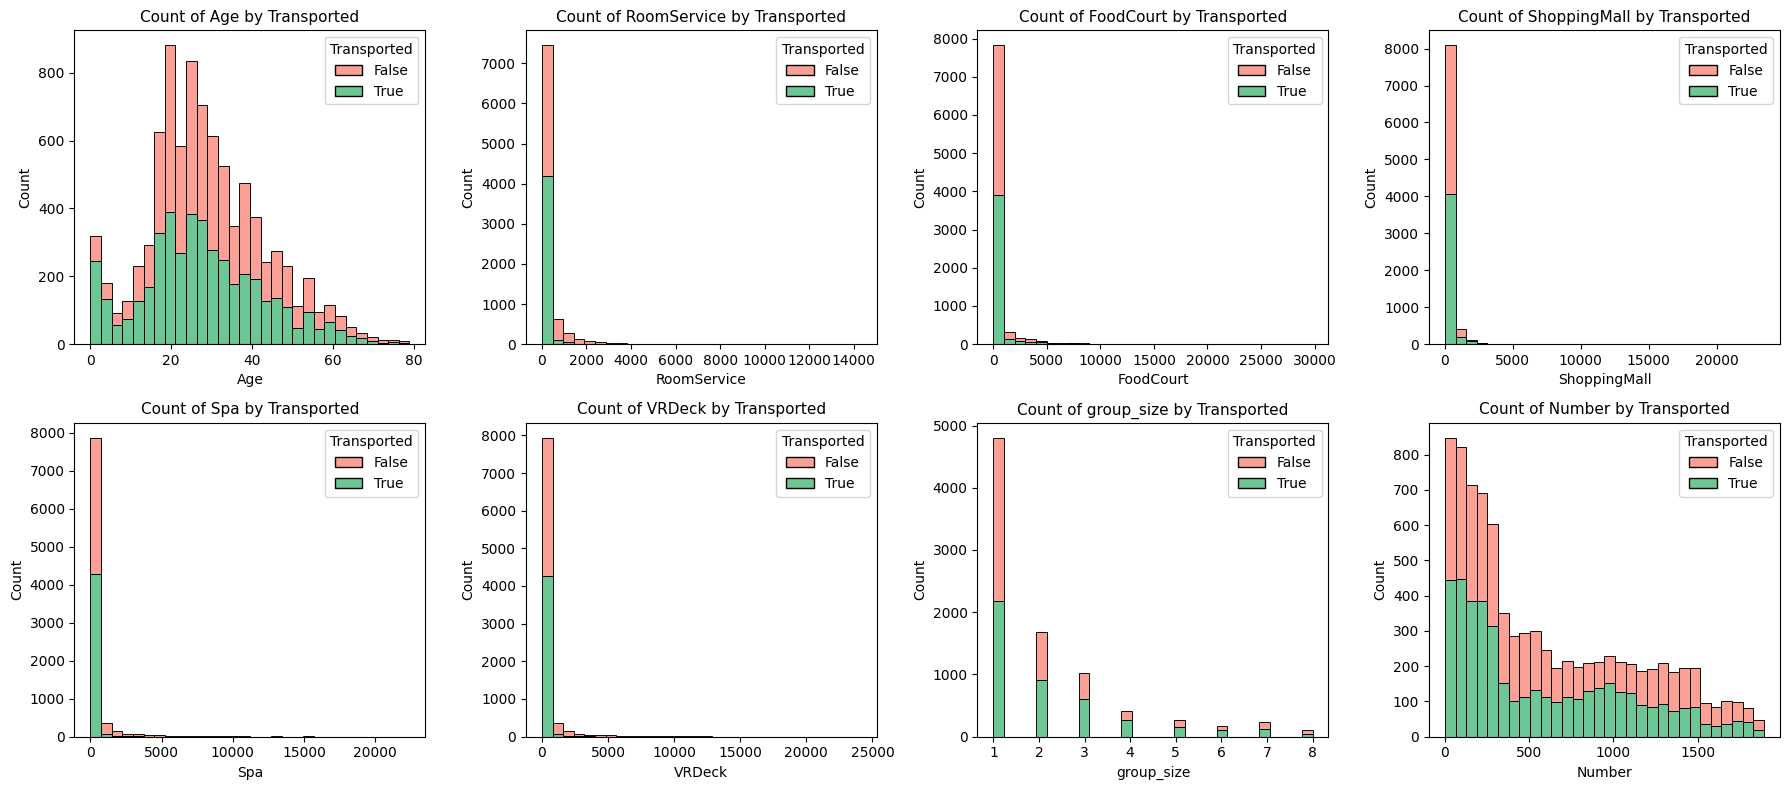

In [14]:
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(numeric):
    sns.histplot(
        data=train_df,
        x=col,
        hue="Transported",
        multiple="stack",
        bins=30,
        palette=["salmon", "mediumseagreen"],
        ax=axes[i],
    )
    axes[i].set_title(f"Count of {col} by Transported", fontsize=11)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

for j in range(len(numeric), 2 * 4):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

* Age: Younger passengers (especially teens and young adults) had a higher probability of being transported.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck: Most passengers spent little or no money on these services. Those who spent very little or nothing tended to have a slightly higher chance of being transported.
* group_size: Smaller group sizes, especially passengers that travels alone are more common, with a slightly higher proportion being transported.
* Number: There's a relatively even distribution of passenger Number, but transported passengers are generally distributed similarly to non-transported ones, with slightly more transported in the lower ranges.

### Bining Numeric Features

#### Binning age in to groups:
* Child: from 0 to 12,
* Teen: from 13 to 18,
* Young Adult: from 19 to 25,
* Adult: from 26 to 40,
* Middle Aged: from 41 to 60,
* Senior: from 61 to 100.

In [15]:
bins = [0, 12, 18, 25, 40, 60, 100]
labels = ["Child", "Teen", "Young Adult", "Adult", "Middle Aged", "Senior"]
train_df["AgeGroup"] = pd.cut(train_df["Age"], bins=bins, labels=labels, right=False)

#### Combining all spending features into one variable.

In [16]:
train_df["Total_spend"] = train_df[
    ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
].sum(axis=1)

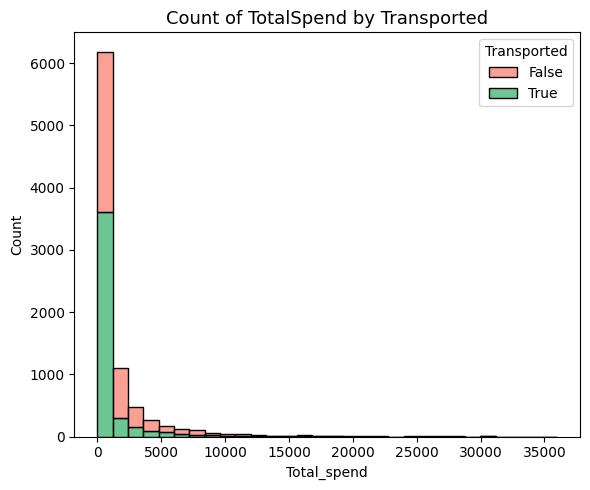

In [17]:
plt.figure(figsize=(6, 5))
sns.histplot(
    data=train_df,
    x="Total_spend",
    hue="Transported",
    multiple="stack",
    bins=30,
    palette=["salmon", "mediumseagreen"],
)
plt.title("Count of TotalSpend by Transported", fontsize=13)
plt.xlabel("Total_spend")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Passengers who spent less overall were more likely to be transported.

So we going to bin this in to groups:
* No spend,
* From 1 to 3k,
* From 3k to 5k,
* From 5k to 10k,
* More than 10k.

In [18]:
def bin_total_spend(val):
    if val == 0:
        return "No Spend"
    elif val <= 3000:
        return "0–3k"
    elif val <= 5000:
        return "3k–5k"
    elif val <= 10000:
        return "5k–10k"
    else:
        return "10k+"


train_df["TotalSpend_group"] = train_df["Total_spend"].apply(bin_total_spend)
bin_order = ["No Spend", "0–3k", "3k–5k", "5k–10k", "10k+"]

cat_type = CategoricalDtype(categories=bin_order, ordered=True)
train_df["TotalSpend_group"] = train_df["TotalSpend_group"].astype(cat_type)

#### Spending feature

In [19]:
train_df["Spending"] = train_df["Total_spend"].apply(
    lambda x: "Spent" if x > 0 else "No Spend"
)
train_df["Spending"] = train_df["Spending"].astype("category")

#### Room Numbers bin into 4 sections:
* 1 section: 0 to 473,
* 2 section: 473 to 947,
* 3 section: 947 to 1420,
* 4 section: 1420 +

In [20]:
bins = [-1, 473, 947, 1420, float("inf")]
labels = ["section_1", "section_2", "section_3", "section_4"]

train_df["Number_Section"] = pd.cut(train_df["Number"], bins=bins, labels=labels)

### Categorical Variable

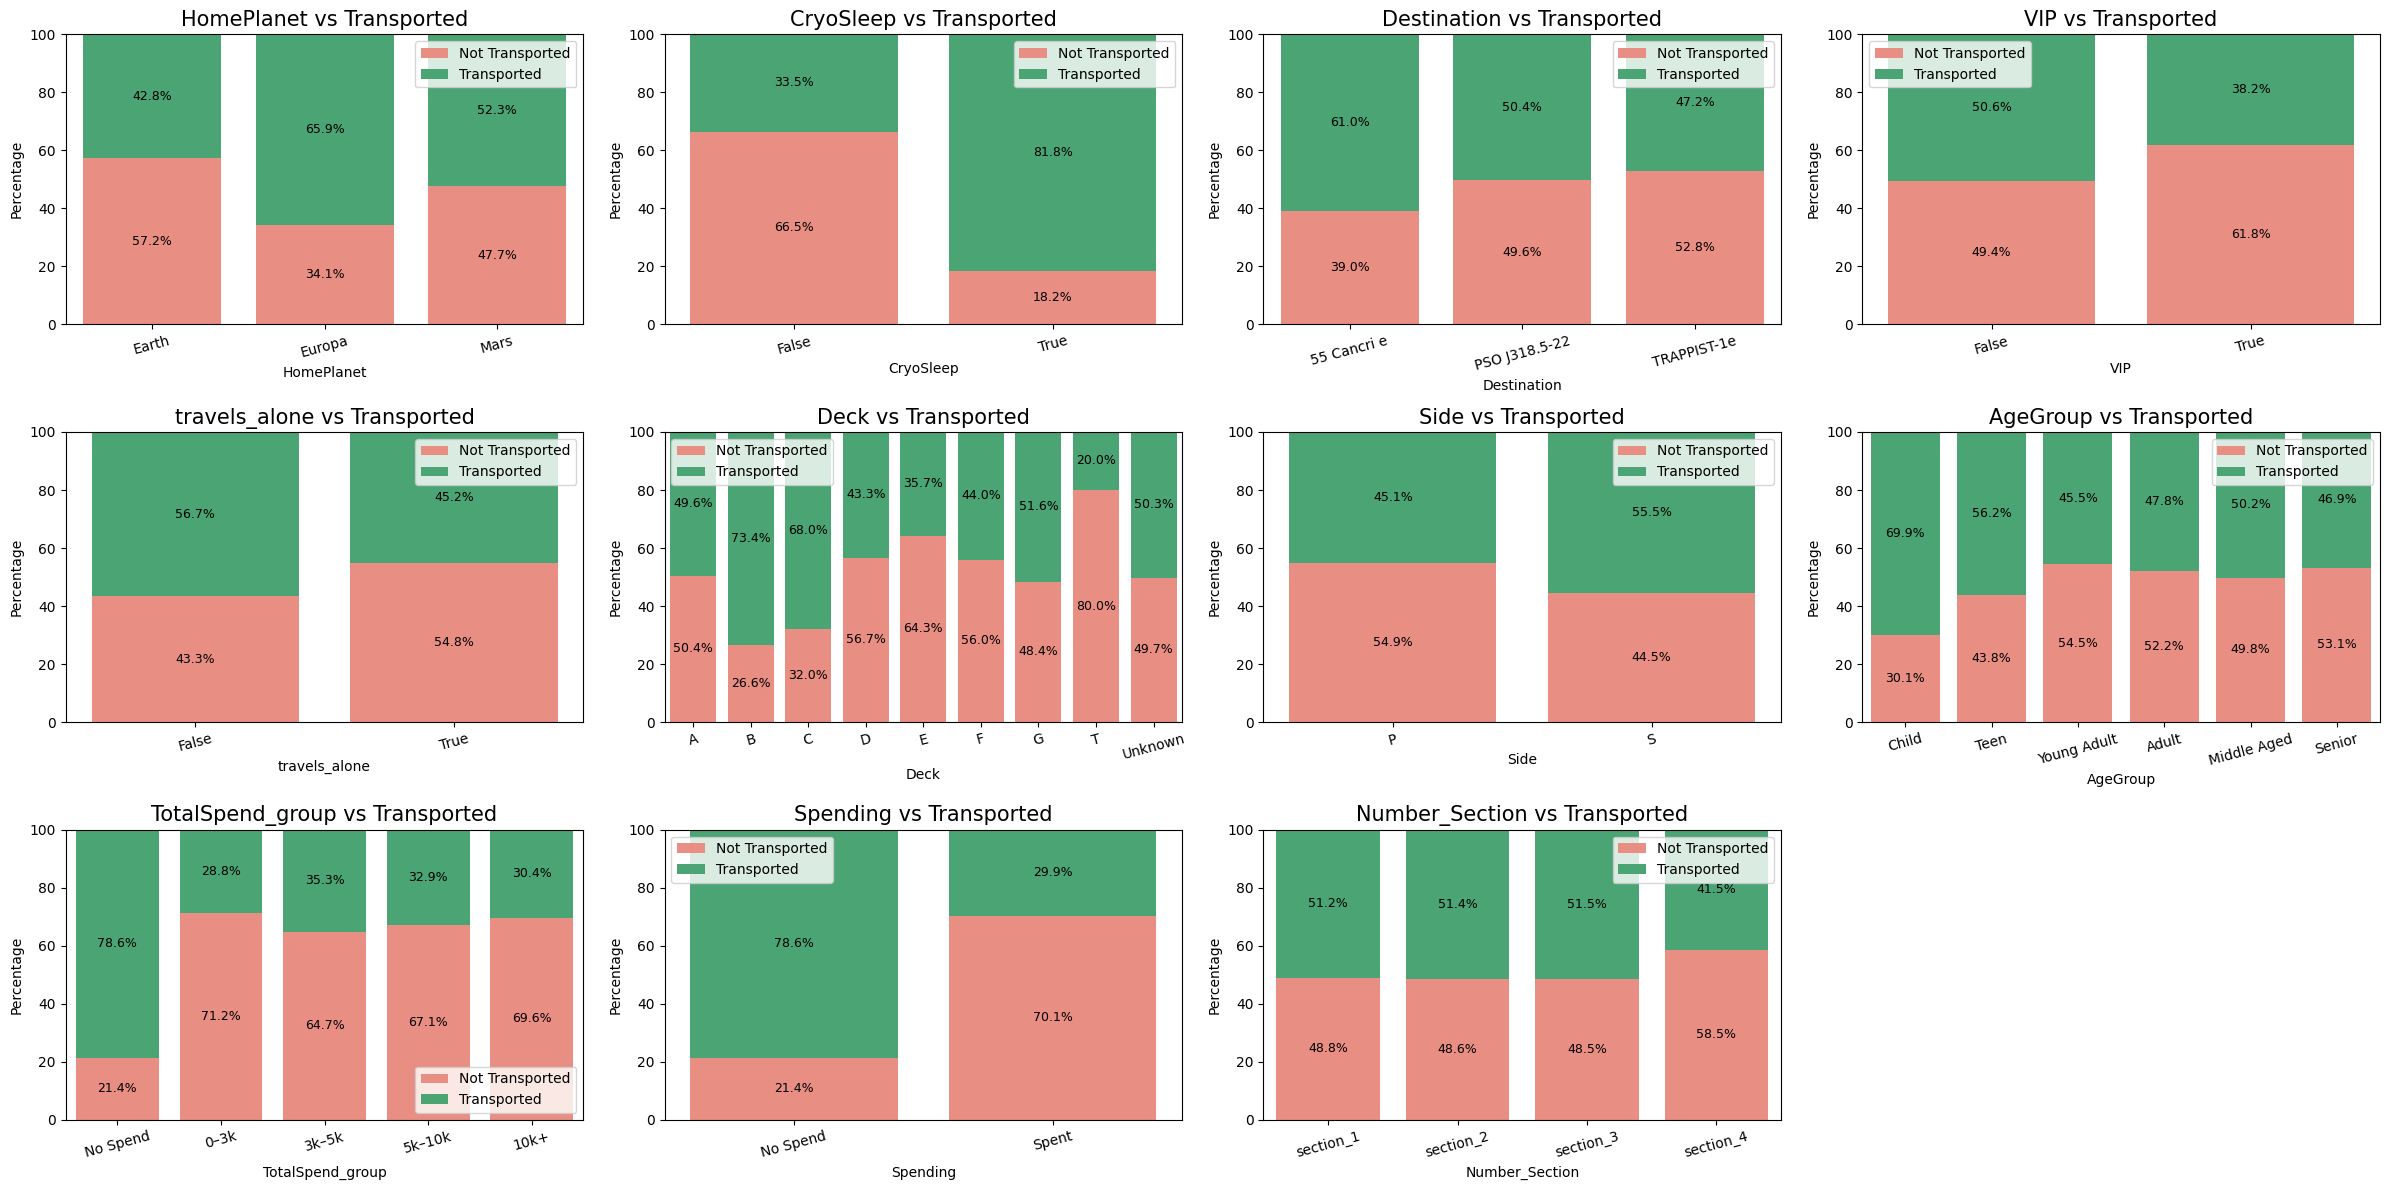

In [21]:
categorical = [
    "HomePlanet",
    "CryoSleep",
    "Destination",
    "VIP",
    "travels_alone",
    "Deck",
    "Side",
    "AgeGroup",
    "TotalSpend_group",
    "Spending",
    "Number_Section",
]

cols = 4
rows = math.ceil(len(categorical) / cols)

plt.figure(figsize=(6 * cols, 4 * rows))

for i, col in enumerate(categorical, 1):
    plt.subplot(rows, cols, i)

    percentages = (
        train_df.groupby(col)["Transported"]
        .value_counts(normalize=True)
        .unstack()
        .fillna(0)
        * 100
    )

    sns.barplot(
        x=percentages.index,
        y=percentages[False],
        color="salmon",
        label="Not Transported",
    )
    sns.barplot(
        x=percentages.index,
        y=percentages[True],
        bottom=percentages[False],
        color="mediumseagreen",
        label="Transported",
    )

    for idx, val in enumerate(percentages.index):
        y0 = percentages[False][val]
        y1 = percentages[True][val]
        plt.text(idx, y0 / 2, f"{y0:.1f}%", ha="center", va="center", fontsize=9)
        plt.text(idx, y0 + y1 / 2, f"{y1:.1f}%", ha="center", va="center", fontsize=9)

    plt.title(f"{col} vs Transported", fontsize=15)
    plt.xlabel(col)
    plt.ylabel("Percentage")
    plt.ylim(0, 100)
    plt.xticks(rotation=15)

    if i == 1:
        plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

* HomePlanet: Passengers from Europa had a significantly higher transport rate (66%) compared to those from Earth and Mars.
* CryoSleep: Passengers in CryoSleep were much more likely to be transported (82%) than those not in CryoSleep.
* Destination: Passengers headed to 55 Cancri e had the highest transport rate, while TRAPPIST-1e passengers had the lowest.
* VIP: Not VIP passengers (51%) were more likely to be transported than VIP (38%).
* Travels alone: Passengers that travel not alone (57%) were more likely to be transported than passengers that travel in group (45%).
* Deck: Decks B and C had notably higher transport rates; G had the lowest (20%).
* Side: Passengers on the S side were more likely to be transported (55%) than those on the P side (45%).
* AgeGroup: Children and Teens had the highest transport rates, which declined steadily with age.
* TotalSpend_group: Passengers with no spend had the highest chance of being transported (79%). Transport rate decreased with spend level. The lowest transported rate is 0-3K spending.
* Spending: Passengers that didn't spend money had significantly higher transport rate (79%) compared to those that did spend money (30%).
* Number_Section: Sections 1 to 3 had similar transport rates (~51%), while Section 4 had a noticeably lower rate (42%).

### Correlation Between Features

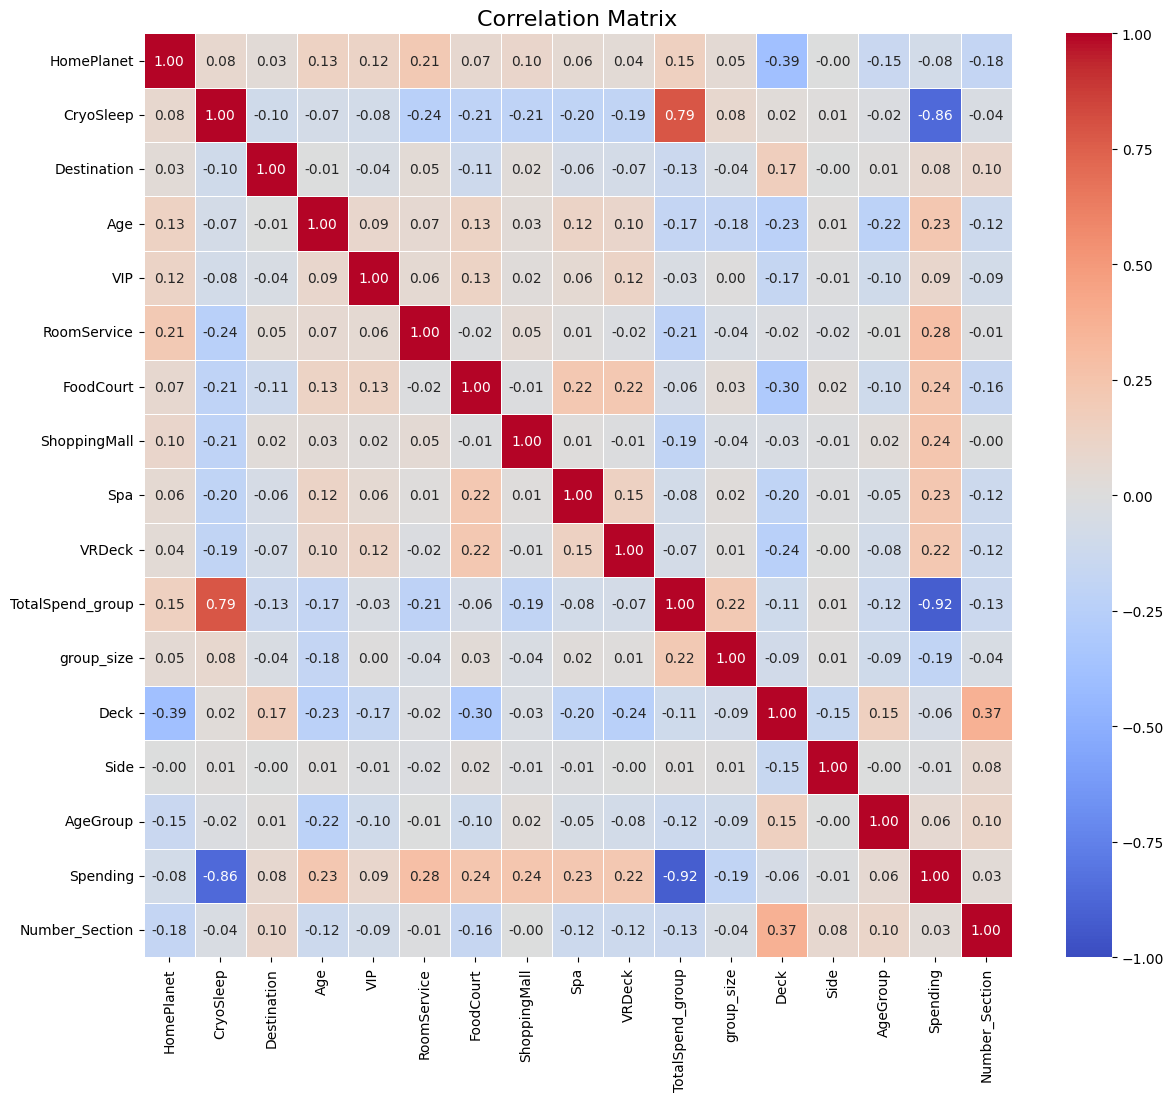

In [22]:
le = LabelEncoder()

for col in categorical + ["Transported"]:
    train_df[col] = le.fit_transform(train_df[col].astype(str))

corr_features = [
    "HomePlanet",
    "CryoSleep",
    "Destination",
    "Age",
    "VIP",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "TotalSpend_group",
    "group_size",
    "Deck",
    "Side",
    "AgeGroup",
    "Spending",
    "Number_Section",
]

corr_matrix = train_df[corr_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1
)
plt.title("Correlation Matrix", fontsize=16)
plt.show()

In here we can see that strongest positive correlation is between total spend group and cryo sleep (0.75) and strongest negative correalation is between spending and total spending group (-0.92) and cryosleep (-0.86).

### Correlation between Transported (target variable) and other features

In [23]:
correlation_results = {}
features = corr_features.copy()

for col in features:
    try:
        corr_coefficient, p_value = pearsonr(train_df["Transported"], train_df[col])
        correlation_results[col] = (corr_coefficient, p_value)
    except Exception as e:
        print(f"Error computing correlation for {col}: {e}")

correlation_df = pd.DataFrame(correlation_results, index=["Correlation", "P-Value"]).T
correlation_df = correlation_df.sort_values(by="Correlation", ascending=False).round(4)

correlation_df

,Correlation,P-Value
CryoSleep,0.4601,0.0000
TotalSpend_group,0.4529,0.0000
HomePlanet,0.1155,0.0000
Side,0.0935,0.0000
group_size,0.0826,0.0000
FoodCourt,0.0456,0.0000
ShoppingMall,0.0094,0.3813
AgeGroup,-0.0237,0.0269
Number_Section,-0.0348,0.0012
VIP,-0.0373,0.0005


Strongest statistically significant positive correlation are with CryoSleep (0.4601, p > 0.05) and Total Spend group (0.4259, p > 0.05) and strongest statisticly significant negative correlation is with Spending (-0.4816, p > 0.05).

## Statistical Inference

Target population: Spaceship Titanic passengers.

We have two groups:
1. People who have been transported
2. People who have not been transported

In [24]:
transported = train_df[train_df["Transported"] == 1]
not_transported = train_df[train_df["Transported"] == 0]

Does travelers who choice to travel with CryoSleep are more likely to get transported?

Hypothesis:
* Null Hypothesis (H₀): Being in CryoSleep has no effect on whether a passenger was transported.
* Alternative Hypothesis (H₁): There is an association between CryoSleep status and Transported outcome.

In [25]:
contingency_table = pd.crosstab(train_df["CryoSleep"], train_df["Transported"])

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("p-value:", p_value)

Chi-square statistic: 1838.5677340571679
p-value: 0.0


Since the p-value is significantly less than the typical alpha level of 0.05, we reject the null hypothesis.
There is strong statistical evidence of an association between CryoSleep and whether a passenger was transported. This suggests that CryoSleep status is a relevant factor in determining the outcome.

In [26]:
cryo_true = train_df[train_df["CryoSleep"] == True]
cryo_false = train_df[train_df["CryoSleep"] == False]

success_cryo = cryo_true["Transported"].sum()
total_cryo = len(cryo_true)

success_no_cryo = cryo_false["Transported"].sum()
total_no_cryo = len(cryo_false)

ci_cryo = proportion_confint(
    count=success_cryo, nobs=total_cryo, alpha=0.05, method="normal"
)
ci_no_cryo = proportion_confint(
    count=success_no_cryo, nobs=total_no_cryo, alpha=0.05, method="normal"
)

print("CryoSleep = True:")
print(f"Proportion Transported: {success_cryo / total_cryo:.3f}")
print(f"95% Confidence Interval: {ci_cryo}\n")

print("CryoSleep = False:")
print(f"Proportion Transported: {success_no_cryo / total_no_cryo:.3f}")
print(f"95% Confidence Interval: {ci_no_cryo}")

CryoSleep = True:
Proportion Transported: 0.818
95% Confidence Interval: (0.8038482841583114, 0.8313179983573289)

CryoSleep = False:
Proportion Transported: 0.335
95% Confidence Interval: (0.3227414371992378, 0.34734342843018223)


There is strong statistical evidence that passengers who chose CryoSleep were significantly more likely to be transported than those who did not. With an observed proportion of 81.8% vs. 33.5% and non-overlapping 95% confidence intervals, we can conclude the association is both practically and statistically significant.

## Apply various machine learning models

In [27]:
df_ml = pd.read_csv("train.csv")

In [28]:
X = df_ml.drop(columns=["Transported"])
y = df_ml["Transported"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Models with No Feature Engineering

#### Functions for Pipeline

In [29]:
def impute_missing_values_raw_data(df):
    df = df.copy()

    for col in ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]:
        df[col].fillna(df[col].median(), inplace=True)
    for col in ["HomePlanet", "CryoSleep", "Destination", "VIP"]:
        df[col].fillna(df[col].mode()[0], inplace=True)
    for col in ["Cabin", "Name"]:
        df[col].fillna("Unknown", inplace=True)

    return df


def encode_and_cleanup(df):
    df = df.copy()

    categorical = [
        "HomePlanet",
        "CryoSleep",
        "Destination",
        "VIP",
        "Cabin",
    ]
    le = LabelEncoder()
    for col in categorical:
        df[col] = le.fit_transform(df[col].astype(str))
    df.drop(columns=["PassengerId", "Name"], inplace=True, errors="ignore")

    return df

#### Pipelines

In [30]:
preprocessor = Pipeline(
    steps=[
        ("impute", FunctionTransformer(impute_missing_values_raw_data)),
        ("encode_cleanup", FunctionTransformer(encode_and_cleanup)),
    ]
)

preprocessor_no_impute = Pipeline(
    steps=[
        ("encode_cleanup", FunctionTransformer(encode_and_cleanup)),
    ]
)

random_forest_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)

xgboost_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_no_impute),
        ("classifier", XGBClassifier(random_state=42)),
    ]
)

logistic_regression_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(random_state=42)),
    ]
)

gradient_boosting_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", GradientBoostingClassifier(random_state=42)),
    ]
)

svm_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", SVC(probability=True, random_state=42)),
    ]
)

knn_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier())]
)

lgbm_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_no_impute),
        ("classifier", LGBMClassifier(random_state=42)),
    ]
)

catboost_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_no_impute),
        ("classifier", CatBoostClassifier(random_seed=42)),
    ]
)

#### Results

In [31]:
models = {
    "Random Forest": random_forest_pipeline,
    "XGBoost": xgboost_pipeline,
    "Logistic Regression": logistic_regression_pipeline,
    "Gradient Boosting": gradient_boosting_pipeline,
    "SVM": svm_pipeline,
    "KNN": knn_pipeline,
    "LightGBM": lgbm_pipeline,
    "CatBoost": catboost_pipeline,
}

model_results = {}

for model_name, model_pipeline in models.items():
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_val)
    y_pred_proba = model_pipeline.predict_proba(X_val)[:, 1]

    accuracy = accuracy_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    f1_score_0 = f1_score(y_val, y_pred, pos_label=0)
    f1_score_1 = f1_score(y_val, y_pred, pos_label=1)

    model_results[model_name] = [accuracy, roc_auc, f1_score_0, f1_score_1]

df_results = pd.DataFrame(
    model_results,
    index=["Accuracy", "ROC-AUC", "F1-Score (No Transport)", "F1-Score (Transported)"],
).T

df_results.style.background_gradient(cmap="Blues")

C:\Users\japer\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1623
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
Learning rate set to 0.023581
0:	learn: 0.6821143	total: 159ms	remaining: 2m 38s
1:	learn: 0.6709715	total: 215ms	remaining: 1m 47s
2:	learn: 0.6612791	total: 246ms	remaining: 1m 21s
3:	learn: 0.6512889	total: 275ms	remaining: 1m 8s
4:	learn: 0.6406524	total: 292ms	remaining: 58.1s
5:	learn: 0.6315450	total: 305ms	remaining: 50.5s
6:	learn: 0.6228717	total: 313ms	remaining: 44.4s
7:	learn: 0.6152623	total: 324ms	remaining: 40.2s
8:	learn: 0.60

,Accuracy,ROC-AUC,F1-Score (No Transport),F1-Score (Transported)
Random Forest,0.778608,0.843780,0.763368,0.792004
XGBoost,0.750431,0.849869,0.710667,0.780586
Logistic Regression,0.781484,0.854916,0.753567,0.803719
Gradient Boosting,0.784359,0.866974,0.761602,0.803150
SVM,0.779183,0.847593,0.745358,0.805076
KNN,0.743531,0.810773,0.737028,0.749719
LightGBM,0.747556,0.861159,0.703978,0.779950
CatBoost,0.780909,0.867489,0.754352,0.802283


On the raw dataset, with only basic missing value handling and encoding, model accuracies ranged from 74.35% to 78.43%.

The highest accuracy was achieved by Gradient Boosting (78.43%), followed by Logistic Regression (78.15%) and CatBoost (78.09%).

The lowest-performing models were KNN (74.35%) and LightGBM (74.76%).

Overall, this baseline highlights areas where improvements can be made with feature engineering.

### Feature Engineering

#### Functions

In [32]:
def feature_engineering(df):
    """
    Perform feature engineering on the dataset to create new informative variables.

    This function:
    - Extracts group size and solo travel status from PassengerId
    - Bins Age into age groups
    - Splits Cabin into Deck, Number, and Side, and bins cabin numbers into sections
    - Calculates total spending across services and creates both continuous and categorical spend features

    Parameters:
        df (pd.DataFrame): Original dataset

    Returns:
        pd.DataFrame: Dataset with new engineered features added
    """

    df = df.copy()

    group_id = df["PassengerId"].apply(lambda x: x.split("_")[0])

    df["group_size"] = group_id.map(group_id.value_counts())

    df["travels_alone"] = df["group_size"] == 1

    age_bins = [0, 12, 18, 25, 40, 60, 100]

    age_labels = ["Child", "Teen", "Young Adult", "Adult", "Middle Aged", "Senior"]

    df["AgeGroup"] = pd.cut(df["Age"], bins=age_bins, labels=age_labels, right=False)

    df[["Deck", "Number", "Side"]] = df["Cabin"].str.split("/", expand=True)

    df["Number"] = pd.to_numeric(df["Number"], errors="coerce").astype("Int64")

    bins = [-1, 473, 947, 1420, float("inf")]

    labels = ["section_1", "section_2", "section_3", "section_4"]

    df["Number_Section"] = pd.cut(df["Number"], bins=bins, labels=labels)

    df["Total_spend"] = df[
        ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
    ].sum(axis=1)

    def bin_total_spend(val):

        if val == 0:

            return "No Spend"

        elif val <= 3000:

            return "0–3k"

        elif val <= 5000:

            return "3k–5k"

        elif val <= 10000:

            return "5k–10k"

        else:

            return "10k+"

    df["TotalSpend_group"] = df["Total_spend"].apply(bin_total_spend)

    bin_order = ["No Spend", "0–3k", "3k–5k", "5k–10k", "10k+"]

    cat_type = CategoricalDtype(categories=bin_order, ordered=True)

    df["TotalSpend_group"] = df["TotalSpend_group"].astype(cat_type)

    df["Spending"] = df["Total_spend"].apply(lambda x: "Spent" if x > 0 else "No Spend")

    df["Spending"] = df["Spending"].astype("category")

    return df


def impute_missing_values(df):

    df = df.copy()
    for col in [
        "Age",
        "RoomService",
        "FoodCourt",
        "ShoppingMall",
        "Spa",
        "VRDeck",
        "group_size",
        "Number",
    ]:

        df[col].fillna(df[col].median(), inplace=True)
    for col in [
        "HomePlanet",
        "CryoSleep",
        "Destination",
        "VIP",
        "travels_alone",
        "AgeGroup",
        "Deck",
        "Side",
        "TotalSpend_group",
    ]:

        df[col].fillna(df[col].mode()[0], inplace=True)

    for col in ["Cabin", "Name"]:

        df[col].fillna("Unknown", inplace=True)
    return df


def encode_and_cleanup(df):

    df = df.copy()
    categorical = [
        "HomePlanet",
        "CryoSleep",
        "Destination",
        "VIP",
        "Cabin",
        "AgeGroup",
        "Deck",
        "Side",
        "Number_Section",
        "TotalSpend_group",
        "Spending",
    ]

    le = LabelEncoder()

    for col in categorical:

        df[col] = le.fit_transform(df[col].astype(str))

    df.drop(
        columns=[
            "PassengerId",
            "Name",
            "Age",
            "group_size",
            "Cabin",
            "Number",
            "Total_spend",
        ],
        inplace=True,
        errors="ignore",
    )
    return df

#### Pipeline

In [33]:
preprocessor = Pipeline(
    steps=[
        ("feature_engineering", FunctionTransformer(feature_engineering)),
        ("impute", FunctionTransformer(impute_missing_values)),
        ("encode_cleanup", FunctionTransformer(encode_and_cleanup)),
    ]
)

preprocessor_no_impute = Pipeline(
    steps=[
        ("feature_engineering", FunctionTransformer(feature_engineering)),
        ("encode_cleanup", FunctionTransformer(encode_and_cleanup)),
    ]
)

random_forest_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)

xgboost_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_no_impute),
        ("classifier", XGBClassifier(random_state=42)),
    ]
)

logistic_regression_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(random_state=42)),
    ]
)

gradient_boosting_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", GradientBoostingClassifier(random_state=42)),
    ]
)

svm_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", SVC(probability=True))]
)

knn_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier())]
)

lgbm_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_no_impute),
        ("classifier", LGBMClassifier(random_state=42)),
    ]
)

catboost_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_no_impute),
        ("classifier", CatBoostClassifier(random_seed=42)),
    ]
)

#### Results

In [34]:
models = {
    "Random Forest": random_forest_pipeline,
    "XGBoost": xgboost_pipeline,
    "Logistic Regression": logistic_regression_pipeline,
    "Gradient Boosting": gradient_boosting_pipeline,
    "SVM": svm_pipeline,
    "KNN": knn_pipeline,
    "LightGBM": lgbm_pipeline,
    "CatBoost": catboost_pipeline,
}

model_results = {}

for model_name, model_pipeline in models.items():
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_val)
    y_pred_proba = model_pipeline.predict_proba(X_val)[:, 1]

    accuracy = accuracy_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    f1_score_0 = f1_score(y_val, y_pred, pos_label=0)
    f1_score_1 = f1_score(y_val, y_pred, pos_label=1)

    model_results[model_name] = [accuracy, roc_auc, f1_score_0, f1_score_1]

df_results = pd.DataFrame(
    model_results,
    index=["Accuracy", "ROC-AUC", "F1-Score (No Transport)", "F1-Score (Transported)"],
).T

df_results.style.background_gradient(cmap="Blues")

C:\Users\japer\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
Learning rate set to 0.023581
0:	learn: 0.6815385	total: 11.8ms	remaining: 11.8s
1:	learn: 0.6714126	total: 24.1ms	remaining: 12s
2:	learn: 0.6616214	total: 56.9ms	remaining: 18.9s
3:	learn: 0.6515929	total: 87.3ms	remaining: 21.7s
4:	learn: 0.6419598	total: 111ms	remaining: 22s
5:	learn: 0.6336415	total: 126ms	remaining: 20.9s
6:	learn: 0.6255668	total: 142ms	remaining: 20.1s
7:	learn: 0.6172674	total: 150ms	remaining: 18.6s
8:	learn: 0.61015

,Accuracy,ROC-AUC,F1-Score (No Transport),F1-Score (Transported)
Random Forest,0.795285,0.882944,0.798643,0.791813
XGBoost,0.797010,0.889379,0.797476,0.796542
Logistic Regression,0.782059,0.873128,0.778233,0.785755
Gradient Boosting,0.803335,0.894538,0.796186,0.810000
SVM,0.791259,0.863553,0.770978,0.808241
KNN,0.767683,0.850321,0.768614,0.766744
LightGBM,0.806210,0.897809,0.803039,0.809281
CatBoost,0.801035,0.897844,0.796948,0.804961


After applying feature engineering, model performance improved overall, with accuracies now ranging between 76.77% and 80.62%.

The best-performing model is LightGBM, achieving the highest accuracy at 80.62%, followed closely by Gradient Boosting (80.33%) and CatBoost (80.10%).

The lowest-performing model is KNN, with an accuracy of 76.77%, making it less suitable for this task.

These results show that feature engineering had a positive impact, especially for tree-based models.

### Tuning Models with Feature Engineering

#### Hyperparameter Tuning Functions for Each Model

In [35]:
def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_float("max_features", 0.2, 1.0),
    }
    rf_classifier = RandomForestClassifier(**params, random_state=42)
    rf_pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", rf_classifier)]
    )
    rf_pipeline.fit(X_train, y_train)
    accuracy = rf_pipeline.score(X_val, y_val)

    return accuracy


def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "use_label_encoder": False,
        "eval_metric": "logloss",
    }
    xgb_classifier = XGBClassifier(**params, random_state=42)
    xgb_pipeline = Pipeline(
        steps=[("preprocessor", preprocessor_no_impute), ("classifier", xgb_classifier)]
    )
    xgb_pipeline.fit(X_train, y_train)
    accuracy = xgb_pipeline.score(X_val, y_val)

    return accuracy


def objective_log_reg(trial):
    params = {
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
        "solver": trial.suggest_categorical("solver", ["liblinear", "saga"]),
        "C": trial.suggest_float("C", 0.01, 100.0, log=True),
        "max_iter": 1000,
    }
    if params["penalty"] == "l1" and params["solver"] not in ["liblinear", "saga"]:
        raise optuna.exceptions.TrialPruned()
    if params["penalty"] == "l2" and params["solver"] not in ["liblinear", "saga"]:
        raise optuna.exceptions.TrialPruned()
    lr_classifier = LogisticRegression(**params, random_state=42)
    lr_pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", lr_classifier)]
    )
    lr_pipeline.fit(X_train, y_train)
    accuracy = lr_pipeline.score(X_val, y_val)

    return accuracy


def objective_gb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
    }
    gb_classifier = GradientBoostingClassifier(**params, random_state=1)
    gb_pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", gb_classifier)]
    )
    gb_pipeline.fit(X_train, y_train)
    accuracy = gb_pipeline.score(X_val, y_val)

    return accuracy


def objective_svm(trial):
    params = {
        "C": trial.suggest_float("C", 0.1, 100, log=True),
        "kernel": "rbf",
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
        "probability": True,
    }
    svm_classifier = SVC(**params, random_state=42)
    svm_pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", svm_classifier)]
    )
    svm_pipeline.fit(X_train, y_train)
    accuracy = svm_pipeline.score(X_val, y_val)

    return accuracy


def objective_knn(trial):
    params = {
        "n_neighbors": trial.suggest_int("n_neighbors", 3, 15),
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        "p": trial.suggest_categorical("p", [1, 2]),
    }
    knn_classifier = KNeighborsClassifier(**params)
    knn_pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", knn_classifier)]
    )
    knn_pipeline.fit(X_train, y_train)
    accuracy = knn_pipeline.score(X_val, y_val)

    return accuracy


def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_categorical("num_leaves", [15, 31, 63, 127]),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
    }
    lgbm_classifier = LGBMClassifier(**params, random_state=42)
    lgbm_pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor_no_impute),
            ("classifier", lgbm_classifier),
        ]
    )
    lgbm_pipeline.fit(X_train, y_train)
    accuracy = lgbm_pipeline.score(X_val, y_val)

    return accuracy


def objective_cb(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 300, step=100),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, step=0.01),
        "verbose": 0,
    }
    cb_classifier = CatBoostClassifier(**params, random_state=42)
    catboost_pipeline = Pipeline(
        steps=[("preprocessor", preprocessor_no_impute), ("classifier", cb_classifier)]
    )
    catboost_pipeline.fit(X_train, y_train)
    accuracy = catboost_pipeline.score(X_val, y_val)

    return accuracy

#### Running Optuna

In [36]:
optuna_results = {}


def run_model_pipeline(model_name, objective_func, model_pipeline):
    study = create_study(direction="maximize")
    study.optimize(objective_func, n_trials=50)
    best_params = study.best_params
    best_accuracy = study.best_value

    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_val)
    y_pred_proba = model_pipeline.predict_proba(X_val)[:, 1]

    roc_auc = roc_auc_score(y_val, y_pred_proba)
    f1_0 = f1_score(y_val, y_pred, pos_label=0)
    f1_1 = f1_score(y_val, y_pred, pos_label=1)

    optuna_results[model_name] = {
        "Best Hyperparameters": best_params,
        "Best Accuracy": best_accuracy,
        "ROC-AUC": roc_auc,
        "F1-Score (No Transport)": f1_0,
        "F1-Score (Transported)": f1_1,
    }


model_configs = {
    "Random Forest": (objective_rf, random_forest_pipeline),
    "XGBoost": (objective_xgb, xgboost_pipeline),
    "Logistic Regression": (objective_log_reg, logistic_regression_pipeline),
    "Gradient Boosting": (objective_gb, gradient_boosting_pipeline),
    "SVM": (objective_svm, svm_pipeline),
    "KNN": (objective_knn, knn_pipeline),
    "LightGBM": (objective_lgbm, lgbm_pipeline),
    "CatBoost": (objective_cb, catboost_pipeline),
}

for model_name, (objective_func, model_pipeline) in model_configs.items():
    run_model_pipeline(model_name, objective_func, model_pipeline)

df_optuna_results = pd.DataFrame.from_dict(optuna_results, orient="index")
df_optuna_results.style.background_gradient(cmap="Blues")

[I 2025-04-18 14:27:28,227] A new study created in memory with name: no-name-aeda4306-1436-421c-b37a-a77a439153c3


[I 2025-04-18 14:27:41,077] Trial 0 finished with value: 0.8050603795284647 and parameters: {'n_estimators': 700, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 0.3324324821079759}. Best is trial 0 with value: 0.8050603795284647.
[I 2025-04-18 14:27:44,530] Trial 1 finished with value: 0.8050603795284647 and parameters: {'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 0.8270895004406049}. Best is trial 0 with value: 0.8050603795284647.
[I 2025-04-18 14:27:58,249] Trial 2 finished with value: 0.8079355951696378 and parameters: {'n_estimators': 400, 'max_depth': 23, 'min_samples_split': 19, 'min_samples_leaf': 8, 'max_features': 0.8834203829140048}. Best is trial 2 with value: 0.8079355951696378.
[I 2025-04-18 14:28:16,674] Trial 3 finished with value: 0.8079355951696378 and parameters: {'n_estimators': 700, 'max_depth': 25, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 0.601340304638

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:20:01,492] Trial 0 finished with value: 0.8016101207590569 and parameters: {'num_leaves': 31, 'n_estimators': 400, 'learning_rate': 0.029484281254566078}. Best is trial 0 with value: 0.8016101207590569.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:20:13,807] Trial 1 finished with value: 0.7849338700402531 and parameters: {'num_leaves': 127, 'n_estimators': 450, 'learning_rate': 0.14023339263621798}. Best is trial 0 with value: 0.8016101207590569.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:20:19,539] Trial 2 finished with value: 0.8062104657849338 and parameters: {'num_leaves': 63, 'n_estimators': 400, 'learning_rate': 0.02410992118766617}. Best is trial 2 with value: 0.8062104657849338.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:20:20,730] Trial 3 finished with value: 0.8062104657849338 and parameters: {'num_leaves': 15, 'n_estimators': 300, 'learning_rate': 0.024657283055395465}. Best is trial 2 with value: 0.8062104657849338.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:20:21,540] Trial 4 finished with value: 0.8067855089131685 and parameters: {'num_leaves': 15, 'n_estimators': 200, 'learning_rate': 0.030109761109483983}. Best is trial 4 with value: 0.8067855089131685.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:20:35,070] Trial 5 finished with value: 0.7941345600920069 and parameters: {'num_leaves': 127, 'n_estimators': 500, 'learning_rate': 0.07545820822266948}. Best is trial 4 with value: 0.8067855089131685.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:20:37,090] Trial 6 finished with value: 0.8090856814261069 and parameters: {'num_leaves': 31, 'n_estimators': 250, 'learning_rate': 0.011657048411856207}. Best is trial 6 with value: 0.8090856814261069.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:20:44,030] Trial 7 finished with value: 0.79700977573318 and parameters: {'num_leaves': 63, 'n_estimators': 500, 'learning_rate': 0.042091441852857486}. Best is trial 6 with value: 0.8090856814261069.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:20:45,103] Trial 8 finished with value: 0.8056354226566993 and parameters: {'num_leaves': 15, 'n_estimators': 250, 'learning_rate': 0.028972914289430107}. Best is trial 6 with value: 0.8090856814261069.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:20:51,289] Trial 9 finished with value: 0.8039102932719954 and parameters: {'num_leaves': 63, 'n_estimators': 450, 'learning_rate': 0.026966201601663294}. Best is trial 6 with value: 0.8090856814261069.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:20:51,844] Trial 10 finished with value: 0.7952846463484762 and parameters: {'num_leaves': 31, 'n_estimators': 50, 'learning_rate': 0.010867517125718188}. Best is trial 6 with value: 0.8090856814261069.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:20:52,775] Trial 11 finished with value: 0.8004600345025877 and parameters: {'num_leaves': 15, 'n_estimators': 200, 'learning_rate': 0.010035358773069183}. Best is trial 6 with value: 0.8090856814261069.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:20:53,699] Trial 12 finished with value: 0.8016101207590569 and parameters: {'num_leaves': 31, 'n_estimators': 100, 'learning_rate': 0.013882609002271017}. Best is trial 6 with value: 0.8090856814261069.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:20:54,441] Trial 13 finished with value: 0.7993099482461185 and parameters: {'num_leaves': 15, 'n_estimators': 150, 'learning_rate': 0.07174233549235907}. Best is trial 6 with value: 0.8090856814261069.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:20:56,895] Trial 14 finished with value: 0.8108108108108109 and parameters: {'num_leaves': 31, 'n_estimators': 300, 'learning_rate': 0.015917303228782202}. Best is trial 14 with value: 0.8108108108108109.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:20:59,251] Trial 15 finished with value: 0.8096607245543416 and parameters: {'num_leaves': 31, 'n_estimators': 300, 'learning_rate': 0.016215279034099278}. Best is trial 14 with value: 0.8108108108108109.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:21:02,038] Trial 16 finished with value: 0.8033352501437608 and parameters: {'num_leaves': 31, 'n_estimators': 350, 'learning_rate': 0.017262688777661163}. Best is trial 14 with value: 0.8108108108108109.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:21:04,222] Trial 17 finished with value: 0.7929844738355377 and parameters: {'num_leaves': 31, 'n_estimators': 300, 'learning_rate': 0.2662249917296462}. Best is trial 14 with value: 0.8108108108108109.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:21:06,889] Trial 18 finished with value: 0.8067855089131685 and parameters: {'num_leaves': 31, 'n_estimators': 350, 'learning_rate': 0.016937322705438136}. Best is trial 14 with value: 0.8108108108108109.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:21:09,499] Trial 19 finished with value: 0.8004600345025877 and parameters: {'num_leaves': 31, 'n_estimators': 350, 'learning_rate': 0.04133092642893504}. Best is trial 14 with value: 0.8108108108108109.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:21:14,696] Trial 20 finished with value: 0.8102357676825762 and parameters: {'num_leaves': 127, 'n_estimators': 200, 'learning_rate': 0.018231211730059576}. Best is trial 14 with value: 0.8108108108108109.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:21:19,924] Trial 21 finished with value: 0.8085106382978723 and parameters: {'num_leaves': 127, 'n_estimators': 200, 'learning_rate': 0.017451305871753753}. Best is trial 14 with value: 0.8108108108108109.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:21:23,746] Trial 22 finished with value: 0.8108108108108109 and parameters: {'num_leaves': 127, 'n_estimators': 150, 'learning_rate': 0.018754930173725374}. Best is trial 14 with value: 0.8108108108108109.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:21:27,397] Trial 23 finished with value: 0.8027602070155262 and parameters: {'num_leaves': 127, 'n_estimators': 150, 'learning_rate': 0.048279390139150224}. Best is trial 14 with value: 0.8108108108108109.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:21:30,226] Trial 24 finished with value: 0.8079355951696378 and parameters: {'num_leaves': 127, 'n_estimators': 100, 'learning_rate': 0.020811680339323423}. Best is trial 14 with value: 0.8108108108108109.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:21:32,899] Trial 25 finished with value: 0.8050603795284647 and parameters: {'num_leaves': 127, 'n_estimators': 100, 'learning_rate': 0.013476089870317695}. Best is trial 14 with value: 0.8108108108108109.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:21:36,835] Trial 26 finished with value: 0.7993099482461185 and parameters: {'num_leaves': 127, 'n_estimators': 150, 'learning_rate': 0.06671801225673568}. Best is trial 14 with value: 0.8108108108108109.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:21:43,683] Trial 27 finished with value: 0.7924094307073031 and parameters: {'num_leaves': 127, 'n_estimators': 250, 'learning_rate': 0.11437335589872247}. Best is trial 14 with value: 0.8108108108108109.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:21:45,200] Trial 28 finished with value: 0.8056354226566993 and parameters: {'num_leaves': 127, 'n_estimators': 50, 'learning_rate': 0.03806814032676166}. Best is trial 14 with value: 0.8108108108108109.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:21:50,517] Trial 29 finished with value: 0.8010350776308223 and parameters: {'num_leaves': 127, 'n_estimators': 200, 'learning_rate': 0.035211443073959084}. Best is trial 14 with value: 0.8108108108108109.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:21:52,795] Trial 30 finished with value: 0.8113858539390454 and parameters: {'num_leaves': 63, 'n_estimators': 150, 'learning_rate': 0.021330340966403294}. Best is trial 30 with value: 0.8113858539390454.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:21:55,192] Trial 31 finished with value: 0.8125359401955147 and parameters: {'num_leaves': 63, 'n_estimators': 150, 'learning_rate': 0.020835594203460463}. Best is trial 31 with value: 0.8125359401955147.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:21:57,433] Trial 32 finished with value: 0.8125359401955147 and parameters: {'num_leaves': 63, 'n_estimators': 150, 'learning_rate': 0.021944875672881108}. Best is trial 31 with value: 0.8125359401955147.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:21:59,040] Trial 33 finished with value: 0.8090856814261069 and parameters: {'num_leaves': 63, 'n_estimators': 100, 'learning_rate': 0.022207066645335515}. Best is trial 31 with value: 0.8125359401955147.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:21:59,961] Trial 34 finished with value: 0.7924094307073031 and parameters: {'num_leaves': 63, 'n_estimators': 50, 'learning_rate': 0.01416909844824897}. Best is trial 31 with value: 0.8125359401955147.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:22:03,680] Trial 35 finished with value: 0.8056354226566993 and parameters: {'num_leaves': 63, 'n_estimators': 250, 'learning_rate': 0.031291967269501446}. Best is trial 31 with value: 0.8125359401955147.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:22:06,043] Trial 36 finished with value: 0.8142610695802185 and parameters: {'num_leaves': 63, 'n_estimators': 150, 'learning_rate': 0.02391982503432123}. Best is trial 36 with value: 0.8142610695802185.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:22:08,427] Trial 37 finished with value: 0.8142610695802185 and parameters: {'num_leaves': 63, 'n_estimators': 150, 'learning_rate': 0.02245861810758711}. Best is trial 36 with value: 0.8142610695802185.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:22:10,102] Trial 38 finished with value: 0.8148361127084531 and parameters: {'num_leaves': 63, 'n_estimators': 100, 'learning_rate': 0.05477430119192025}. Best is trial 38 with value: 0.8148361127084531.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:22:11,699] Trial 39 finished with value: 0.8050603795284647 and parameters: {'num_leaves': 63, 'n_estimators': 100, 'learning_rate': 0.05833779183868191}. Best is trial 38 with value: 0.8148361127084531.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:22:12,605] Trial 40 finished with value: 0.8131109833237493 and parameters: {'num_leaves': 63, 'n_estimators': 50, 'learning_rate': 0.09442236889049074}. Best is trial 38 with value: 0.8148361127084531.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:22:13,526] Trial 41 finished with value: 0.8067855089131685 and parameters: {'num_leaves': 63, 'n_estimators': 50, 'learning_rate': 0.09573330821968695}. Best is trial 38 with value: 0.8148361127084531.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:22:15,047] Trial 42 finished with value: 0.7958596894767107 and parameters: {'num_leaves': 63, 'n_estimators': 100, 'learning_rate': 0.1905347839225747}. Best is trial 38 with value: 0.8148361127084531.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:22:16,007] Trial 43 finished with value: 0.8056354226566993 and parameters: {'num_leaves': 63, 'n_estimators': 50, 'learning_rate': 0.09319105115937884}. Best is trial 38 with value: 0.8148361127084531.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:22:17,607] Trial 44 finished with value: 0.8056354226566993 and parameters: {'num_leaves': 63, 'n_estimators': 100, 'learning_rate': 0.052804137532769}. Best is trial 38 with value: 0.8148361127084531.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:22:20,612] Trial 45 finished with value: 0.8067855089131685 and parameters: {'num_leaves': 63, 'n_estimators': 200, 'learning_rate': 0.15930025686069044}. Best is trial 38 with value: 0.8148361127084531.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:22:21,500] Trial 46 finished with value: 0.8016101207590569 and parameters: {'num_leaves': 63, 'n_estimators': 50, 'learning_rate': 0.025576834329820265}. Best is trial 38 with value: 0.8148361127084531.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:22:23,798] Trial 47 finished with value: 0.8096607245543416 and parameters: {'num_leaves': 63, 'n_estimators': 150, 'learning_rate': 0.0327381503549711}. Best is trial 38 with value: 0.8148361127084531.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:22:25,325] Trial 48 finished with value: 0.8027602070155262 and parameters: {'num_leaves': 63, 'n_estimators': 100, 'learning_rate': 0.08525663606752994}. Best is trial 38 with value: 0.8148361127084531.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:22:26,250] Trial 49 finished with value: 0.8073605520414031 and parameters: {'num_leaves': 63, 'n_estimators': 50, 'learning_rate': 0.12755424632425016}. Best is trial 38 with value: 0.8148361127084531.


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


[I 2025-04-18 15:22:27,180] A new study created in memory with name: no-name-f8cc6d58-08a2-41e3-be37-5d08f3c83f8f
[I 2025-04-18 15:22:27,796] Trial 0 finished with value: 0.7958596894767107 and parameters: {'iterations': 100, 'depth': 5, 'learning_rate': 0.09999999999999999}. Best is trial 0 with value: 0.7958596894767107.
[I 2025-04-18 15:22:30,035] Trial 1 finished with value: 0.7975848188614146 and parameters: {'iterations': 200, 'depth': 8, 'learning_rate': 0.09999999999999999}. Best is trial 1 with value: 0.7975848188614146.
[I 2025-04-18 15:22:31,066] Trial 2 finished with value: 0.7993099482461185 and parameters: {'iterations': 100, 'depth': 8, 'learning_rate': 0.05}. Best is trial 2 with value: 0.7993099482461185.
[I 2025-04-18 15:22:34,461] Trial 3 finished with value: 0.8033352501437608 and parameters: {'iterations': 300, 'depth': 8, 'learning_rate': 0.05}. Best is trial 3 with value: 0.8033352501437608.
[I 2025-04-18 15:22:35,053] Trial 4 finished with value: 0.7952846463484

Learning rate set to 0.023581
0:	learn: 0.6815385	total: 7.3ms	remaining: 7.3s
1:	learn: 0.6714126	total: 15.2ms	remaining: 7.58s
2:	learn: 0.6616214	total: 22.8ms	remaining: 7.58s
3:	learn: 0.6515929	total: 30.5ms	remaining: 7.59s
4:	learn: 0.6419598	total: 35.4ms	remaining: 7.05s
5:	learn: 0.6336415	total: 41.6ms	remaining: 6.9s
6:	learn: 0.6255668	total: 46.9ms	remaining: 6.66s
7:	learn: 0.6172674	total: 51.8ms	remaining: 6.42s
8:	learn: 0.6101561	total: 56.9ms	remaining: 6.27s
9:	learn: 0.6037639	total: 62.5ms	remaining: 6.18s
10:	learn: 0.5963550	total: 66.7ms	remaining: 6s
11:	learn: 0.5895355	total: 70.7ms	remaining: 5.82s
12:	learn: 0.5837382	total: 74.2ms	remaining: 5.63s
13:	learn: 0.5782747	total: 78ms	remaining: 5.49s
14:	learn: 0.5729761	total: 81.2ms	remaining: 5.33s
15:	learn: 0.5680333	total: 84.5ms	remaining: 5.19s
16:	learn: 0.5626315	total: 87.3ms	remaining: 5.04s
17:	learn: 0.5578437	total: 90.1ms	remaining: 4.91s
18:	learn: 0.5532742	total: 92.8ms	remaining: 4.79s


,Best Hyperparameters,Best Accuracy,ROC-AUC,F1-Score (No Transport),F1-Score (Transported)
Random Forest,"{'n_estimators': 600, 'max_depth': 29, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': 0.9383172659268023}",0.810236,0.882944,0.798643,0.791813
XGBoost,"{'n_estimators': 400, 'max_depth': 16, 'learning_rate': 0.022070443549910456, 'min_child_weight': 9, 'subsample': 0.7882409162917722, 'colsample_bytree': 0.7799226686092007}",0.812536,0.889379,0.797476,0.796542
Logistic Regression,"{'penalty': 'l1', 'solver': 'saga', 'C': 0.016351860406433317}",0.794135,0.873128,0.778233,0.785755
Gradient Boosting,"{'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.0130072851991511, 'subsample': 0.7233952367193096}",0.811386,0.894538,0.796186,0.810000
SVM,"{'C': 12.513493565552109, 'gamma': 'scale'}",0.798160,0.863553,0.770978,0.808241
KNN,"{'n_neighbors': 13, 'weights': 'uniform', 'p': 1}",0.789534,0.850321,0.768614,0.766744
LightGBM,"{'num_leaves': 63, 'n_estimators': 100, 'learning_rate': 0.05477430119192025}",0.814836,0.897809,0.803039,0.809281
CatBoost,"{'iterations': 300, 'depth': 4, 'learning_rate': 0.060000000000000005}",0.803910,0.897844,0.796948,0.804961


After feature engineering and hyperparameter tuning, model accuracies ranged from 78.95% to 81.48%.

The highest accuracy was achieved by LightGBM (81.48%), followed by XGBoost (81.25%) and Gradient Boosting (81.14%).

The lowest-performing model was KNN (78.95%), suggesting that this model could still benefit from additional tuning or feature adjustments.

These results highlight that LightGBM, XGBoost, and Random Forest are the best-performing models after feature engineering and tuning, and further improvements may still be possible with additional fine-tuning.

### Trying Model Ensembling with Top 3 Models

In [ ]:
gb_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            GradientBoostingClassifier(
                n_estimators=100,
                max_depth=7,
                learning_rate=0.0130072851991511,
                subsample=0.7233952367193096,
                random_state=42,
            ),
        ),
    ]
)

xgboost_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_no_impute),
        (
            "classifier",
            XGBClassifier(
                n_estimators=400,
                max_depth=16,
                learning_rate=0.022070443549910456,
                min_child_weight=9,
                subsample=0.7882409162917722,
                colsample_bytree=0.7799226686092007,
                use_label_encoder=False,
                eval_metric="logloss",
                random_state=42,
            ),
        ),
    ]
)

lgbm_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_no_impute),
        (
            "classifier",
            LGBMClassifier(
                num_leaves=63,
                n_estimators=100,
                learning_rate=0.05477430119192025,
                random_state=42,
            ),
        ),
    ]
)

In [38]:
ensemble_model = VotingClassifier(
    estimators=[
        ("gradient boositing", gb_pipeline),
        ("xgb", xgboost_pipeline),
        ("lgb", lgbm_pipeline),
    ],
    voting="soft",
)

ensemble_model.fit(X_train, y_train)

y_pred = ensemble_model.predict(X_val)
y_proba = ensemble_model.predict_proba(X_val)[:, 1]

accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_proba)
f1_score_0 = f1_score(y_val, y_pred, pos_label=0)
f1_score_1 = f1_score(y_val, y_pred, pos_label=1)

model_results = {
    "Ensemble (XGB + LGBM + GB)": [accuracy, roc_auc, f1_score_0, f1_score_1]
}

df_results = pd.DataFrame(
    model_results,
    index=["Accuracy", "ROC-AUC", "F1-Score (No Transport)", "F1-Score (Transported)"],
).T

df_results.style.background_gradient(cmap="Blues")

C:\Users\japer\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [16:00:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


,Accuracy,ROC-AUC,F1-Score (No Transport),F1-Score (Transported)
Ensemble (XGB + LGBM + GB),0.813111,0.901586,0.813326,0.812896


The ensemble model show the best overall performance with the highest ROC-AUC and balanced F1 scores, but accuracy for LightGBM model it's better.

So we compare it's confusion matrix with LightGBM to confirm which handles both classes more effectively, to pick our prediction model.

In [39]:
def plot_confusion_matrix(model, X_val, y_val):
    y_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(7, 5))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title("Confusion Matrix")
    ax.xaxis.set_ticklabels(["Have not Transported", "Transported"])
    ax.yaxis.set_ticklabels(["Have not Transported", "Transported"])

    plt.show()

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


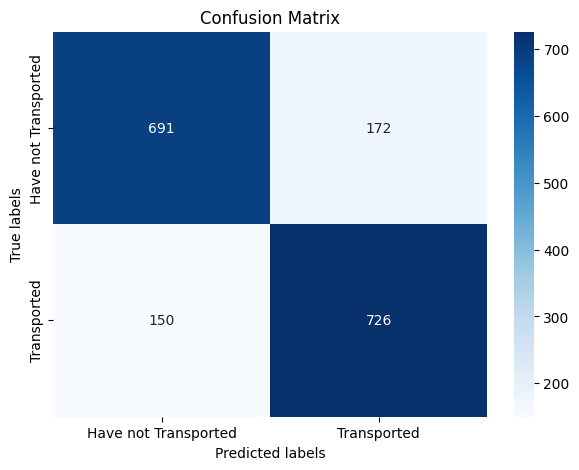

In [41]:
lgbm_pipeline.fit(X_train, y_train)
lgbm_prediction = lgbm_pipeline.predict(X_val)
plot_confusion_matrix(lgbm_pipeline, X_val, y_val)

In LightGBM model confusion matrix we see that:
* Transported group: correctly predicted 726 and incorrectly predicted 150,
* Have not Transported: correctly predicted 691 and incorrectly predicted 172.

C:\Users\japer\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [16:23:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


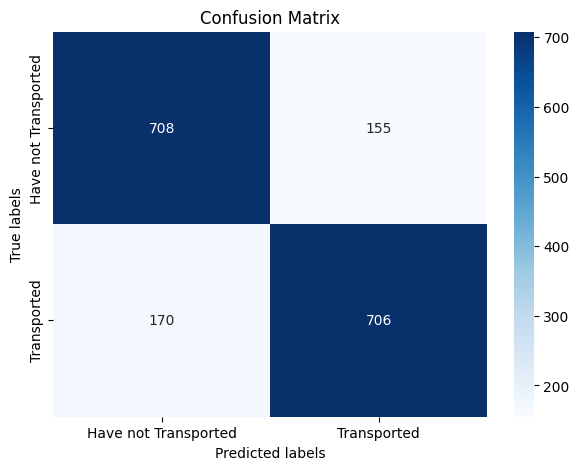

In [42]:
ensemble_model.fit(X_train, y_train)
ensemble_model_prediction = ensemble_model.predict(X_val)
plot_confusion_matrix(ensemble_model, X_val, y_val)

In Ensembled model confusion matrix we see that:
* Transported group: correctly predicted 708 and incorrectly predicted 155,
* Have not Transported: correctly predicted 706 and incorrectly predicted 708.

So we going to use LightGBM because it correctly predicted more "Transported" cases and had fewer false positives compared to the ensemble, indicating better balanced and more accurate classification overall

## Final Model

In [43]:
preprocessor_no_impute = Pipeline(
    steps=[
        ("feature_engineering", FunctionTransformer(feature_engineering)),
        ("encode_cleanup", FunctionTransformer(encode_and_cleanup)),
    ]
)

lgbm_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_no_impute),
        (
            "classifier",
            LGBMClassifier(
                num_leaves=63,
                n_estimators=100,
                learning_rate=0.05477430119192025,
                random_state=42,
            ),
        ),
    ]
)

In [ ]:
test_df = pd.read_csv("test.csv")

lgbm_pipeline.fit(X_train, y_train)
lgbm_model_prediction = lgbm_pipeline.predict(test_df)


lgbm_model_prediction = lgbm_model_prediction.astype(bool)
submission = pd.read_csv("sample_submission.csv")



submission["Transported"] = lgbm_model_prediction



submission.to_csv("lighGBM_submition.csv", index=False)

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


## Conclusion

### Statistical Analysis:
* CryoSleep do have impact on if passenger is trasnported or not.

### Machine Learning Models Preformance
* On raw data best preformining model - Gradient Boosting with accuracy 78.43%,
* On feature engineered data best preforming model - LightGBM with accuracy 80.62%,
* After tuning best model was still LightGBM and even better than model ensebled model with accuracy 81.48 %.

### Kaggle Score for Test Data:
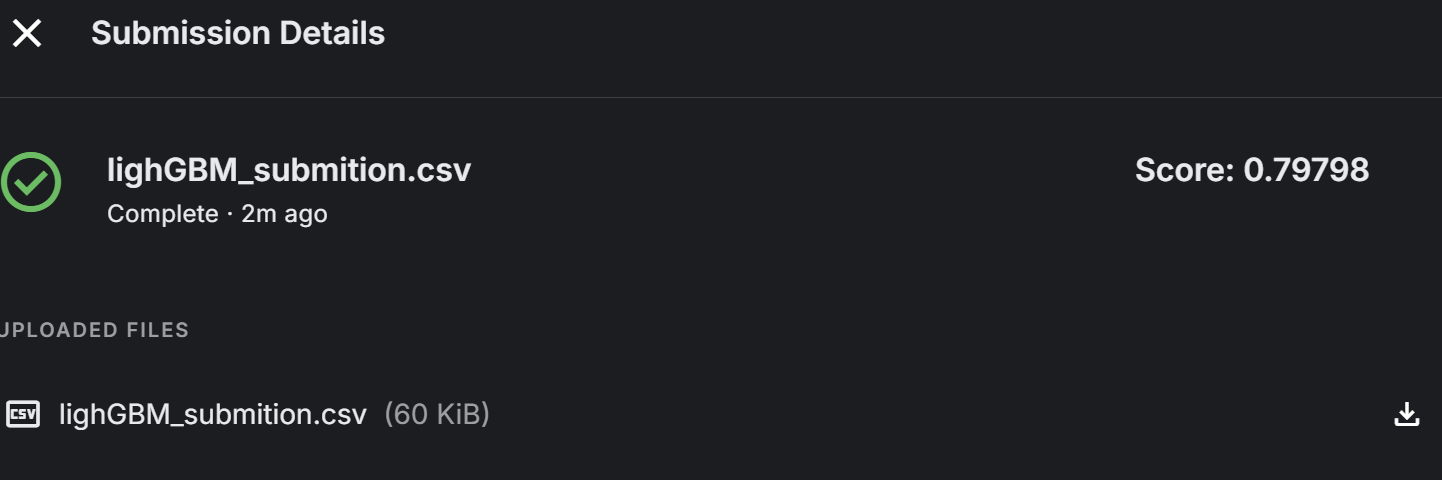


## Suggestions for Improvement

* Do more data preperation and feature enigineering to help improve models predictions.